TRAIN_DIR: C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


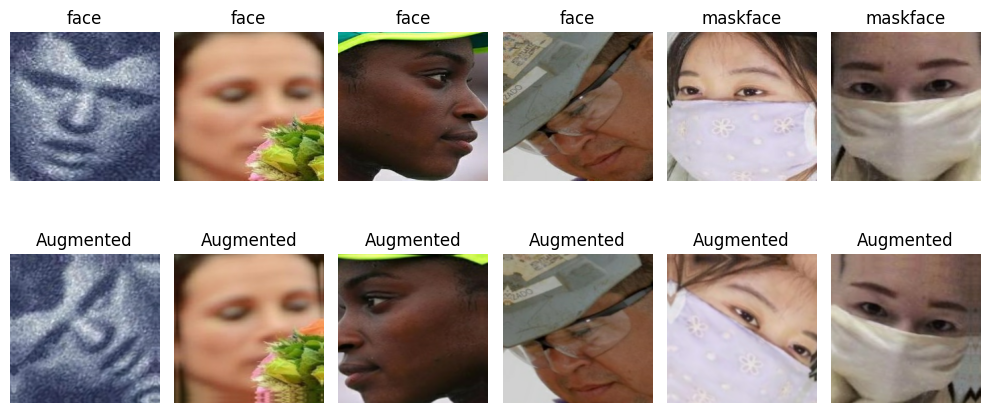

In [1]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

### Cellule – Modèle 6 (EfficientNetB0 gelé) : Architecture

Dans cette cellule, on construit le **Modèle 6** basé sur **EfficientNetB0**, un backbone moderne particulièrement efficace grâce à sa combinaison optimisée de profondeur, largeur et résolution (compound scaling).  
Ici, tout le backbone est **gelé** : aucun fine-tuning n’est appliqué.

---

### 🔹 1. Backbone EfficientNetB0 pré-entraîné

- `EfficientNetB0(weights="imagenet", include_top=False)`  
  → On conserve toutes les couches convolutionnelles pré-entraînées.

- `base_model_effnet.trainable = False`  
  → Toutes les couches sont gelées :  
    - stable,  
    - rapide à entraîner,  
    - idéal lorsque le dataset est moyen/petit.

**Objectif :**  
Utiliser EfficientNet comme **extracteur de features compact et performant**, sans modifier ses poids.

---

### 🔹 2. Prétraitement de l’entrée

- `data_augmentation` : transformations légères pour améliorer la généralisation.
- `preprocess_input` (spécifique EfficientNet) :  
  → mise à l’échelle et normalisation adaptées au modèle.

**Important :**  
Pas de `Rescaling(1./255)` ici, car `preprocess_input` réalise déjà un pipeline complet.

---

### 🔹 3. Tête de classification

Après la sortie du backbone :

- `GlobalAveragePooling2D()` → réduit chaque carte de features en une valeur moyenne, évitant une explosion du nombre de paramètres.
- `Dense(128, relu)` → petite couche fully-connected pour apprendre une représentation adaptée à la classification.
- `BatchNormalization()` → stabilise et accélère l’entraînement.
- `Dropout(0.5)` → limite le sur-apprentissage malgré la simplicité de la tête.
- `Dense(1, sigmoid)` → sortie binaire (face / maskface).

Tête simple mais efficace, cohérente avec une architecture gelée.

---

### 🔹 Conclusion sur l’architecture

L’ensemble forme un modèle :

- léger et rapide à entraîner,
- stable (aucune couche du backbone n’est modifiée),
- bénéficiant des **performances supérieures d’EfficientNet**,
- parfaitement adapté comme deuxième baseline avant un éventuel fine-tuning.



In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [3]:

# Assurer que le dossier existe
os.makedirs("models", exist_ok=True)

## Compilation + callbacks (Modèle 6)

On utilise :
- Adam avec learning rate standard (1e-3) car le backbone est gelé
- binary_crossentropy
- accuracy, precision, recall
- sauvegarde du meilleur modèle
- EarlyStopping + ReduceLROnPlateau

In [4]:
# ------------------ Base EfficientNetB0 (gelée) ------------------
base_model_effnet = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model_effnet.trainable = False  # pas de fine-tuning

print("Nombre de couches totales :", len(base_model_effnet.layers))
print("Nombre de couches trainables :", len([l for l in base_model_effnet.layers if l.trainable]))

# ------------------ Tête de classification ------------------
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)             # seulement en mode training
x = preprocess_input(x)                   # prétraitement officiel EfficientNet

# IMPORTANT : pas de Rescaling ici
x = base_model_effnet(x, training=False)  # on garde les BN en mode inference

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_effnet = keras.Model(inputs, outputs, name="efficientnetb0_frozen")
model_effnet.summary()

Nombre de couches totales : 238
Nombre de couches trainables : 0
Model: "efficientnetb0_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
Model: "efficientnetb0_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
               

## Entraînement du Modèle 6 (EfficientNetB0 gelé)

In [5]:
model_effnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_effnet = ModelCheckpoint(
    "models/efficientnetb0_frozen_best.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,   # <── important
    verbose=1
)

early_stop_effnet = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_effnet = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)


In [7]:
EPOCHS = 20

history_effnet = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_effnet, reduce_lr_effnet, early_stop_effnet],
    verbose=1
)

Epoch 1/20
298/298 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8820 - precision: 0.8808 - recall: 0.8812
Epoch 1: val_loss improved from inf to 0.09147, saving model to models\efficientnetb0_frozen_best.weights.h5

Epoch 1: val_loss improved from inf to 0.09147, saving model to models\efficientnetb0_frozen_best.weights.h5
298/298 [==============================] - 59s 140ms/step - loss: 0.2879 - accuracy: 0.8820 - precision: 0.8808 - recall: 0.8812 - val_loss: 0.0915 - val_accuracy: 0.9655 - val_precision: 0.9556 - val_recall: 0.9789 - lr: 1.0000e-04
Epoch 2/20
298/298 [==============================] - 59s 140ms/step - loss: 0.2879 - accuracy: 0.8820 - precision: 0.8808 - recall: 0.8812 - val_loss: 0.0915 - val_accuracy: 0.9655 - val_precision: 0.9556 - val_recall: 0.9789 - lr: 1.0000e-04
Epoch 2/20
298/298 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9376 - precision: 0.9357 - recall: 0.9385
Epoch 2: val_loss improved from 0.0914

## Courbes Loss & Accuracy (Modèle 6)

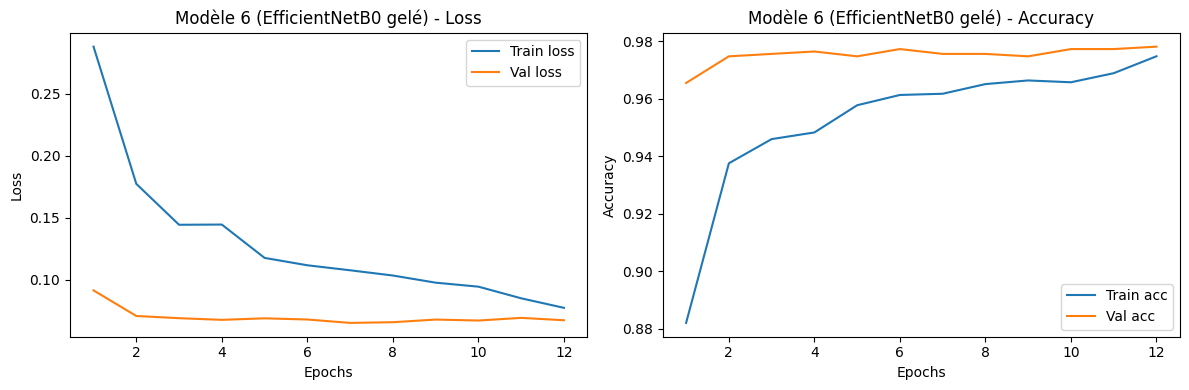

In [8]:
from load import plot_history
plot_history(history_effnet, title_prefix="Modèle 6 (EfficientNetB0 gelé)")

## Évaluation sur le test (Modèle 6)

In [9]:
test_results_effnet = model_effnet.evaluate(test_ds, verbose=1)

print("\nRésultats Modèle 6 (EfficientNetB0 gelé) :")
for name, value in zip(model_effnet.metrics_names, test_results_effnet):
    print(f"{name}: {value:.4f}")

192/192 [==============================] - 12s 63ms/step - loss: 0.0913 - accuracy: 0.9693 - precision: 0.9497 - recall: 0.9606

Résultats Modèle 6 (EfficientNetB0 gelé) :
loss: 0.0913
accuracy: 0.9693
precision: 0.9497
recall: 0.9606


## Matrice de confusion et rapport de classification (Modèle 6)

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = model_effnet.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

192/192 [==============================] - 9s 42ms/step
Confusion Matrix:
 [[1966   53]
 [  41 1000]]

Classification Report:
              precision    recall  f1-score   support

        face       0.98      0.97      0.98      2019
    maskface       0.95      0.96      0.96      1041

    accuracy                           0.97      3060
   macro avg       0.96      0.97      0.97      3060
weighted avg       0.97      0.97      0.97      3060



### Interprétation des résultats – Modèle 6 (EfficientNetB0 gelé)

#### 🔹 Scores sur le test

- `loss = 0.0913`
- `accuracy = 0.9693`
- `precision = 0.9497`
- `recall = 0.9606`

→ Le modèle atteint **≈ 97 % de précision globale**, ce qui est excellent pour un modèle **sans fine-tuning**.

---

### 🔹 Analyse par classe (classification report)

- **face**
  - precision = 0.98  
  - recall = 0.97  
  - f1-score = 0.98  

- **maskface**
  - precision = 0.95  
  - recall = 0.96  
  - f1-score = 0.96  

👉 Les deux classes sont **très bien équilibrées**, ce qui montre que le backbone EfficientNet extrait déjà des features très adaptées.

---

### 🔹 Matrice de confusion

- TN (face → face) = 1966  
- FP (face → maskface) = 53  
- FN (maskface → face) = 41  
- TP (maskface → maskface) = 1000  

→ Très peu d’erreurs globalement, avec un **taux de faux positifs très bas**.

---

### 🔹 Conclusion sur les performances

- EfficientNetB0 gelé surpasse déjà :
  - le CNN baseline,  
  - VGG16 gelé,  
  - plusieurs modèles fine-tunés (sauf les meilleurs).

- C’est le **meilleur modèle gelé** et l’un des plus rapides à entraîner.

- Ses performances se rapprochent fortement du ResNet50 fine-tuné, tout en étant plus simple.

🎯 **Conclusion :** EfficientNetB0 gelé démontre une excellente capacité de généralisation et constitue un backbone très performant même sans fine-tuning.
